In [11]:
import array as arr
import csv
import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [12]:
def step(t, dt):
    t = t + dt
    return t

In [13]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

    #     print("x-loc rectangle,", x, "y-loc rectangle,", y)

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="grey", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')

In [14]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [15]:
class camera(object):
    def __init__(self):      
        
        #################### CLASS VARIABLES ####################
        self.width = 2         # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index

        ######################## MODULES ########################
        self.indexVisFruit = queue.SimpleQueue()
        
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        view_min = q_curr - self.width / 2
        view_max = q_curr + self.width / 2

        # fix end constraints of beginning and end 
        if view_min < 0:
            view_min = 0

        if view_max > end_row:
            view_max = end_row

        i = self.i_lastFruit # might need to change this if fruits move around

        # look through sorted (around y-axis) array to find all "visible fruit"
        while(True):
            if sortedFruit[1,i] > view_min and sortedFruit[1,i] < view_max:
                self.indexVisFruit.put(i)
                
            elif sortedFruit[1,i] > view_max:
                break
            i = i + 1
            
        self.i_lastFruit = i


In [16]:
def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
    i_goal = indexVisFruit.get()
#     print(i_goal)

In [107]:
class arm(object):
    def __init__(self, q):
              
        #################### CLASS VARIABLES ####################
        self.q_a    = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.q_zero = np.array([q[0],q[1],q[2]])  # arm's zero location (can go back to it)
        self.v_a    = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        self.length_f  = 7.      # how far can it go into trees, in m
        self.width_f   = 7.5     # size of enclosing frame, width in m
        self.height_f  = 4.      # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f = np.array([5.5,9.,2.])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f = np.array([0.,0.])
        self.y_edges_f = np.array([0.,0.])
        self.z_edges_f = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max     = 1.
        self.a_max     = 10. 
        self.d_max     = 10.
        
        # can the arm be given a goal, or does it already have one
        self.free      = 1       # start ready to be given a goal 
        self.goal      = np.array([0.,0.,0.])
        self.goal_r    = np.array([0,0,0]) # has the goal been rached at each axis
        
        # Flags
        self.x_move      = 0     # allows the x-dir to start moving
        self.retractFlag = 0     # checks if the arm is retracting
        
        # following the trapezoidal trajectory
        self.t         = 0.      # time at which the arm will begin moving to the goal
        self.tx        = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, q_curr, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # q_curr is the arm's current location within the world frame
        # v_v is the vehicle's velocity
        
#         print("has goal been reached, x, y, z", self.goal_r)

        goal_time   = t - self.t  # time since the y-z self timer was started
        goal_time_x = t - self.tx # time since the x self timer was started => not updating correctly
        
        can_reach = 1  # start with the possibility
    
        # move towards the goal
        self.moveFrame(v_v, dt)    # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time) # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t      # start time for the new timer for x
                    goal_time_x = 0.     # restart the timer for x
                    self.x_move = 1      # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        else:
            # set these at zero and check if arm has to be retracted
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
                self.calcXVel(goal_time_x, v_v)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt
        
        print("edges in X:", self.x_edges_f, "edges in Y:", self.y_edges_f, "edges in Z:", self.z_edges_f)
        
        print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))
        print("")
        
        # if goal has been reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_zero[0]+0.001 or self.q_a[0] < self.q_zero[0]-0.001) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = 0.      # start time for the new timer for x
            elif self.retractFlag == 0:
                self.tx     = 0.
                self.free   = 1 
                self.x_move = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_zero[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        print("RETRACTING")
        print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
        print(" ")
        print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)       
        print(" ")
        
        self.retractFlag = 1
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
        print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
        print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
        print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
        print(" ")
        print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
        print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
        print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
        print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future"
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is passed the edge of the back frame

            if self.goal[2] < self.z_edges_f[0] and self.goal[2] > self.z_edges_f[1]:
                # check again if the goal is within the top and bottom of the frame
                return 1

            else:
                return 0
        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [108]:
# open CSV file and populate fruits on grid
x_fr = []
y_fr = []
z_fr = []

# with open('Applestotheleft.csv', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
#     for row in spamreader:
#         x_fr.append(float(row[0]))
#         y_fr.append(float(row[1]))
#         z_fr.append(float(row[2]))
        
with open('Applestotheright.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        x_fr.append(float(row[0]))
        y_fr.append(float(row[1]))
        z_fr.append(float(row[2]))

x_fruit = np.array(x_fr)
y_fruit = np.array(y_fr)
z_fruit = np.array(z_fr)

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x_fr, y_fr, z_fruit])

rowIndex = 1 # sort based on y-axis
sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [109]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 12.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

dr = drawRobot()

In [110]:
# init vehicle
width_v = 1     # vehicle width
length_v = 5    # vehicle length
num_arms = 1    # set number of arms on robot
q_y  = []     
q_x  = []
q_v = np.array([5.5,9.]) # starting location
v_v = np.array([0.,0.1]) # in m, constant velocity
# v_v = np.array([0.,0.]) # in m, constant velocity

qv0 = []
qv1 = []

In [111]:
# init camera
picture = camera()

In [112]:
# init scheduler
goal = np.zeros(3) # does ithis go here?

In [113]:
# init arms
q_a = np.array([q_v[0],q_v[1],4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms

a1 = arm(q_a) # initialize the arm

# for plotting
error_y = []
error_z = []

qa0 = []
qa1 = []
qa2 = []

left_edge  = []
right_edge = []
front_edge = []
back_edge  = []

In [114]:
##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    picture.cameraStep(end_row, q_v[1], sortedFruit) # resulting in a FIFO queue of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    
    # schedule
    # check if there are any arms that are free 
    for arm_free in range(0,num_arms):
        if a1.free == 1:
            # make sure there are available goals left in the queue
            if not picture.indexVisFruit.empty():
                i_f = picture.indexVisFruit.get()  # get a new goal
        #         print(picture.indexVisFruit.qsize()) # check the size of the queue
                
                # check to which arm the goal should go
                                
                # give the goal 
                a1.setGoal(sortedFruit[:,i_f], t_new)
                # need to add a check to see if the machine can still get it?
            else:
                a1.goal = ([0,0,0]) # clear the goal section I guess

    
    # have each arm take a step
    for arm2step in range(0,num_arms):
        q_a = a1.armStep(v_v, q_a, dt, t_new)
#         print("arm location:", q_a)


#    # when the vehicle is stopped, gives an end to the while loop
#     if a1.error[1] == math.inf or a1.error[1] == -math.inf:
#         print("end of the fruit in y")
#         break
    
#     if a1.error[2] == math.inf or a1.error[2] == -math.inf:
#         print("end of the fruit in z")
#         break

    # list of error btw location and goal coordinates
    error_y.append(float(a1.error[1]))
    error_z.append(float(a1.error[2]))
    
    # plotting data
    q_x.append(float(q_v[0]))  
    q_y.append(float(q_v[1]))
    
    qa0.append(float(a1.q_a[0]))
    qa1.append(float(a1.q_a[1]))
    qa2.append(float(a1.q_a[2]))
    
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(a1.x_edges_f[0]))
#     right_edge.append(float(a1.x_edges_f[1]))
    front_edge.append(float(a1.y_edges_f[0]))
    back_edge.append(float(a1.y_edges_f[1])) 
               
    runs+=1
    

        
        

start, end, start velocity: 5.5 8.1181654718 0
start, end, start velocity: 9.0 8.019408676 0
start, end, start velocity: 4.0 4.7879724914 0
X-axis, Ta: 0.1 Tv: 2.5181654717999993 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.8805913240000006 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.6879724913999997 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: 1.0 10.0 10.0
 
edges in X: [ 5.5 12.5] edges in Y: [12.751  5.251] edges in Z: [4. 0.]
goal:         8.1182  8.0194  4.7880
arm location: 5.5000  9.0010  4.0000

start, end, start velocity: 5.5 9.7717373544 0
start, end, start velocity: 9.001 8.0225264527 0
start, end, start velocity: 4.0 1.0307362359 0
X-axis, Ta: 0.1 Tv: 4.171737354400001 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.8784735473000002 Td: 0.1
Z-axis, Ta: 0.1 Tv: 2.8692637641 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -1.0 -10.0 -10.0
 
edges in X: [ 5.5 12.5] edges in Y: [12.752  5.252] edges in Z: [4. 0.]
goal:   

edges in X: [ 5.5 12.5] edges in Y: [12.892  5.392] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  2.6450

edges in X: [ 5.5 12.5] edges in Y: [12.893  5.393] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  2.6350

edges in X: [ 5.5 12.5] edges in Y: [12.894  5.394] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  2.6250

edges in X: [ 5.5 12.5] edges in Y: [12.895  5.395] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  2.6150

edges in X: [ 5.5 12.5] edges in Y: [12.896  5.396] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  2.6050

edges in X: [ 5.5 12.5] edges in Y: [12.897  5.397] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  2.5950

edges in X: [ 5.5 12.5] edges in Y: [12.898  5.398] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm locat

edges in X: [ 5.5 12.5] edges in Y: [13.028  5.528] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  1.2850

edges in X: [ 5.5 12.5] edges in Y: [13.029  5.529] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  1.2750

edges in X: [ 5.5 12.5] edges in Y: [13.03  5.53] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  1.2650

edges in X: [ 5.5 12.5] edges in Y: [13.031  5.531] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  1.2550

edges in X: [ 5.5 12.5] edges in Y: [13.032  5.532] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  1.2450

edges in X: [ 5.5 12.5] edges in Y: [13.033  5.533] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 5.5000  8.0225  1.2350

edges in X: [ 5.5 12.5] edges in Y: [13.034  5.534] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [13.208  5.708] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 6.9450  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.209  5.709] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 6.9550  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.21  5.71] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 6.9650  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.211  5.711] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 6.9750  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.212  5.712] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 6.9850  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.213  5.713] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 6.9950  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.214  5.714] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [13.328  5.828] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.1450  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.329  5.829] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.1550  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.33  5.83] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.1650  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.331  5.831] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.1750  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.332  5.832] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.1850  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.333  5.833] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.1950  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.334  5.834] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [13.46  5.96] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 9.4650  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.461  5.961] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 9.4750  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.462  5.962] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 9.4850  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.463  5.963] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 9.4950  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.464  5.964] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 9.5050  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.465  5.965] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 9.5150  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.466  5.966] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [13.628  6.128] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.5167  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.629  6.129] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.5067  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.63  6.13] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.4967  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.631  6.131] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.4867  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.632  6.132] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.4767  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.633  6.133] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 8.4667  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.634  6.134] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [13.748  6.248] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 7.3167  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.749  6.249] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 7.3067  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.75  6.25] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 7.2967  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.751  6.251] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 7.2867  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.752  6.252] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 7.2767  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.753  6.253] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm location: 7.2667  8.0225  1.0307

edges in X: [ 5.5 12.5] edges in Y: [13.754  6.254] edges in Z: [4. 0.]
goal:         9.7717  8.0225  1.0307
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [13.94  6.44] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 5.5000  8.0285  1.0367

edges in X: [ 5.5 12.5] edges in Y: [13.941  6.441] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 5.5000  8.0325  1.0407

edges in X: [ 5.5 12.5] edges in Y: [13.942  6.442] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 5.5000  8.0363  1.0457

edges in X: [ 5.5 12.5] edges in Y: [13.943  6.443] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 5.5000  8.0390  1.0517

edges in X: [ 5.5 12.5] edges in Y: [13.944  6.444] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 5.5000  8.0408  1.0567

edges in X: [ 5.5 12.5] edges in Y: [13.945  6.445] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 5.5000  8.0416  1.0607

edges in X: [ 5.5 12.5] edges in Y: [13.946  6.446] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm locatio

goal:         9.9202  8.0417  1.0667
arm location: 6.8950  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.094  6.594] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.9050  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.095  6.595] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.9150  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.096  6.596] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.9250  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.097  6.597] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.9350  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.098  6.598] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.9450  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.099  6.599] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.9550  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.1  

edges in X: [ 5.5 12.5] edges in Y: [14.229  6.729] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.2550  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.23  6.73] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.2650  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.231  6.731] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.2750  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.232  6.732] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.2850  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.233  6.733] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.2950  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.234  6.734] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.3050  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.235  6.735] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [14.378  6.878] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 9.7450  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.379  6.879] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 9.7550  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.38  6.88] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 9.7650  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.381  6.881] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 9.7750  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.382  6.882] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 9.7850  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.383  6.883] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 9.7950  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.384  6.884] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [14.527  7.027] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.7252  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.528  7.028] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.7152  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.529  7.029] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.7052  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.53  7.03] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.6952  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.531  7.031] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.6852  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.532  7.032] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 8.6752  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.533  7.033] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [14.668  7.168] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 7.3152  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.669  7.169] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 7.3052  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.67  7.17] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 7.2952  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.671  7.171] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 7.2852  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.672  7.172] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 7.2752  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.673  7.173] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 7.2652  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.674  7.174] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [14.795  7.295] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.0452  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.796  7.296] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.0352  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.797  7.297] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.0252  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.798  7.298] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.0152  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.799  7.299] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 6.0052  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.8  7.3] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location: 5.9952  8.0416  1.0667

edges in X: [ 5.5 12.5] edges in Y: [14.801  7.301] edges in Z: [4. 0.]
goal:         9.9202  8.0417  1.0667
arm location:

edges in X: [ 5.5 12.5] edges in Y: [14.933  7.433] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  1.7717

edges in X: [ 5.5 12.5] edges in Y: [14.934  7.434] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  1.7817

edges in X: [ 5.5 12.5] edges in Y: [14.935  7.435] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  1.7917

edges in X: [ 5.5 12.5] edges in Y: [14.936  7.436] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  1.8017

edges in X: [ 5.5 12.5] edges in Y: [14.937  7.437] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  1.8117

edges in X: [ 5.5 12.5] edges in Y: [14.938  7.438] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  1.8217

edges in X: [ 5.5 12.5] edges in Y: [14.939  7.439] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm locat

edges in X: [ 5.5 12.5] edges in Y: [15.078  7.578] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  3.2217

edges in X: [ 5.5 12.5] edges in Y: [15.079  7.579] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  3.2317

edges in X: [ 5.5 12.5] edges in Y: [15.08  7.58] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  3.2417

edges in X: [ 5.5 12.5] edges in Y: [15.081  7.581] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  3.2517

edges in X: [ 5.5 12.5] edges in Y: [15.082  7.582] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  3.2617

edges in X: [ 5.5 12.5] edges in Y: [15.083  7.583] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 5.5000  8.0721  3.2717

edges in X: [ 5.5 12.5] edges in Y: [15.084  7.584] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [15.204  7.704] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 6.0350  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.205  7.705] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 6.0450  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.206  7.706] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 6.0550  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.207  7.707] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 6.0650  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.208  7.708] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 6.0750  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.209  7.709] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 6.0850  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.21  7.71] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [15.348  7.848] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.4750  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.349  7.849] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.4850  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.35  7.85] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.4950  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.351  7.851] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.5050  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.352  7.852] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.5150  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.353  7.853] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.5250  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.354  7.854] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm locatio

edges in X: [ 5.5 12.5] edges in Y: [15.492  7.992] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 8.8857  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.493  7.993] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 8.8875  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.494  7.994] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 8.8884  8.0721  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.495  7.995] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 8.8884  8.0721  3.8445

start, end, start velocity: 8.8883629492994 5.5 0
RETRACTING
 
X-axis, Ta: 0.1 Tv: 3.2883629492994007 Td: 0.1
 
reached values, X: -1.0 -10.0 -10.0
 
Should come up right after the RETRACT
time: 27.460000000001493 tx time: 27.460000000001493 goal time: 0.0
edges in X: [ 5.5 12.5] edges in Y: [15.496  7.996] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 8.8884  8.0721  3.8445

edges in

edges in X: [ 5.5 12.5] edges in Y: [15.649  8.149] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.4034  8.1491  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.65  8.15] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.3934  8.1501  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.651  8.151] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.3834  8.1511  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.652  8.152] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.3734  8.1521  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.653  8.153] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.3634  8.1531  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.654  8.154] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm location: 7.3534  8.1541  3.8445

edges in X: [ 5.5 12.5] edges in Y: [15.655  8.155] edges in Z: [4. 0.]
goal:         8.8884  8.0723  3.8445
arm locatio

num runs 3001


<IPython.core.display.Javascript object>


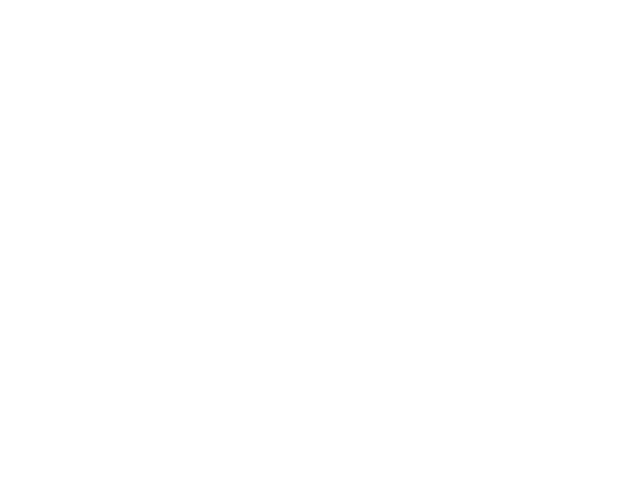

In [115]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(0,runs):
    if run % 20 == 0:
        ax.clear()
        
        ax.scatter(sortedFruit[0,:], sortedFruit[1,:], sortedFruit[2,:], c='r', marker='o') 
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a1.z_edges_f)
        
        ax.scatter(qa0[run], qa1[run], qa2[run], 'b', label='arm1')

        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.5)
       
    
    
fig.show()

